In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
import seaborn as sns

# Data preprocessing

In [2]:
# read a SMILES file into a Pandas dataframe and add an RDKit molecule to the dataframe.
active_df = pd.read_csv("mk01/actives_final.ism", header=None, sep=" ")
active_rows, active_cols = active_df.shape
active_df.columns = ["SMILES", "ID", "ChEMBL_ID"]
active_df["label"] = ["Active"] * active_rows
active_df.head()

,SMILES,ID,ChEMBL_ID,label
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active


In [3]:
PandasTools.AddMoleculeColumnToFrame(active_df, "SMILES", "Mol")

In [4]:
# caculated properties
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

In [5]:
add_property_columns_to_df(active_df)
active_df.head()

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,<rdkit.Chem.rdchem.Mol object at 0x00000125452...,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,<rdkit.Chem.rdchem.Mol object at 0x00000125452...,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,<rdkit.Chem.rdchem.Mol object at 0x00000125452...,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,<rdkit.Chem.rdchem.Mol object at 0x00000125452...,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,<rdkit.Chem.rdchem.Mol object at 0x00000125452...,487.991,5.12922,0


In [6]:
# same for the decoy molecules
decoy_df = pd.read_csv("mk01/decoys_final.ism", header=None, sep=" ")
decoy_df.columns = ["SMILES", "ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"] * decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df, "SMILES", "Mol")
add_property_columns_to_df(decoy_df)
decoy_df.head()

,SMILES,ID,label,Mol,mw,logP,charge
0,C1COCCNC(=S)NCCOCCNC(=S)N1,C03897368,Decoy,<rdkit.Chem.rdchem.Mol object at 0x000002667EF...,292.430,-1.03860,0
1,c1cc(ccc1[C@H]2c3ccc(cc3OC(=C2C#N)N)N)O,C00242247,Decoy,<rdkit.Chem.rdchem.Mol object at 0x000002667EF...,279.299,2.19258,0
2,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2C(=O)C[...,C04096778,Decoy,<rdkit.Chem.rdchem.Mol object at 0x000002667EF...,366.498,1.65330,0
3,Cc1ccc2c(c1)cc(c(=O)[nH]2)[C@@H]3c4c(n[nH]c4OC...,C00421469,Decoy,<rdkit.Chem.rdchem.Mol object at 0x000002667EF...,333.351,2.08622,0
4,Cc1cc2cc(c(=O)[nH]c2cc1C)[C@@H]3c4c(n[nH]c4OC(...,C00421479,Decoy,<rdkit.Chem.rdchem.Mol object at 0x000002667EF...,347.378,2.39464,0


# Compare the properties

In [10]:
tmp_df = pd.concat([active_df, decoy_df])
tmp_df.shape

(4629, 8)

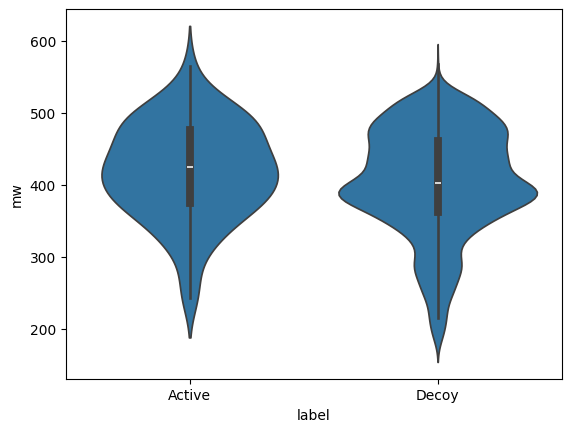

In [12]:
sns.violinplot(x=tmp_df["label"], y=tmp_df["mw"]);

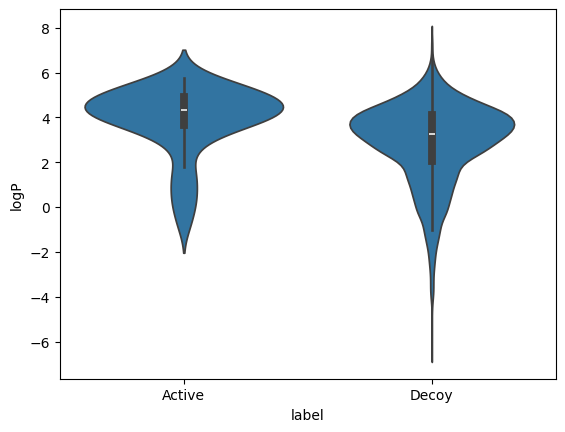

In [13]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["logP"]);


In [14]:
charged = decoy_df[decoy_df["charge"] != 0]
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

In [16]:
from neutralize import NeutraliseCharges

revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

In [17]:
new_tmp_df = pd.concat([active_df, revised_decoy_df])

<Axes: xlabel='label', ylabel='charge'>

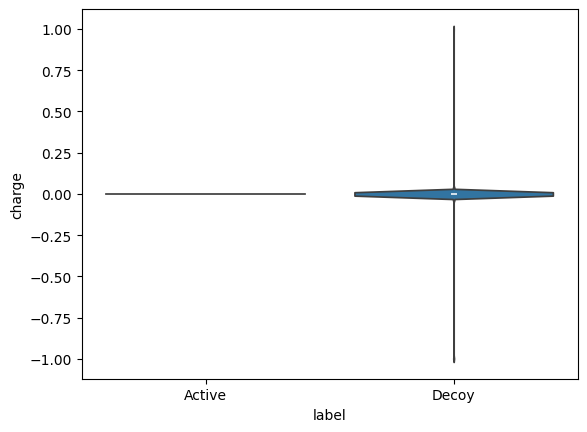

In [18]:
sns.violinplot(x=new_tmp_df["label"],y=new_tmp_df["charge"])


In [19]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

In [20]:
# write the molecules out as a csv file
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = pd.concat([active_df, revised_decoy_df])[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [21]:
combined_df.to_csv("dude_erk1_mk01.csv")